In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from matplotlib.colors import LogNorm
import numpy as np

In [2]:
from analysis.beerdata_loader import BeerDataLoader

data_loader = BeerDataLoader(data_dir="../ada-2024-project-data-crusadas/data/BeerAdvocate", force_process=False)

ba_reviews_df, ba_ratings_df, ba_beers_df, ba_breweries_df, ba_users_df = data_loader.load_all_data()

print("Reviews DataFrame:")
print(ba_reviews_df.head())

print("\nRatings DataFrame:")
print(ba_ratings_df.head())

print("\nBeers DataFrame:")
print(ba_beers_df.head())

print("\nBreweries DataFrame:")
print(ba_breweries_df.head())

print("\nUsers DataFrame:")
print(ba_users_df.head())

Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\ratings_processed.csv' already exists. Skipping processing.
Reviews DataFrame:
       beer_name  beer_id                               brewery_name  \
0          Régab   142544  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv        date        user_name  \
0       37262   Euro Pale Lager  4.5  1440064800          nmann08   
1       10093  English Pale Ale  4.5  1235127600      StJamesGate   
2       10093  English Pale Ale  4.5  1142247600          mdagnew   
3       10093  E

**First question to ask: what is the ditribution of reviewers accross countries?**

             cleaned_location  nbr_ratings
137  United States of America      7303870
28                     Canada       274512
136            United Kingdom        41597
11                  Australia        34915
123                    Sweden        29914
90                Netherlands        22952
50                    Germany        17460
106                   Romania        16823
16                    Belgium        16478
107                    Russia        10521


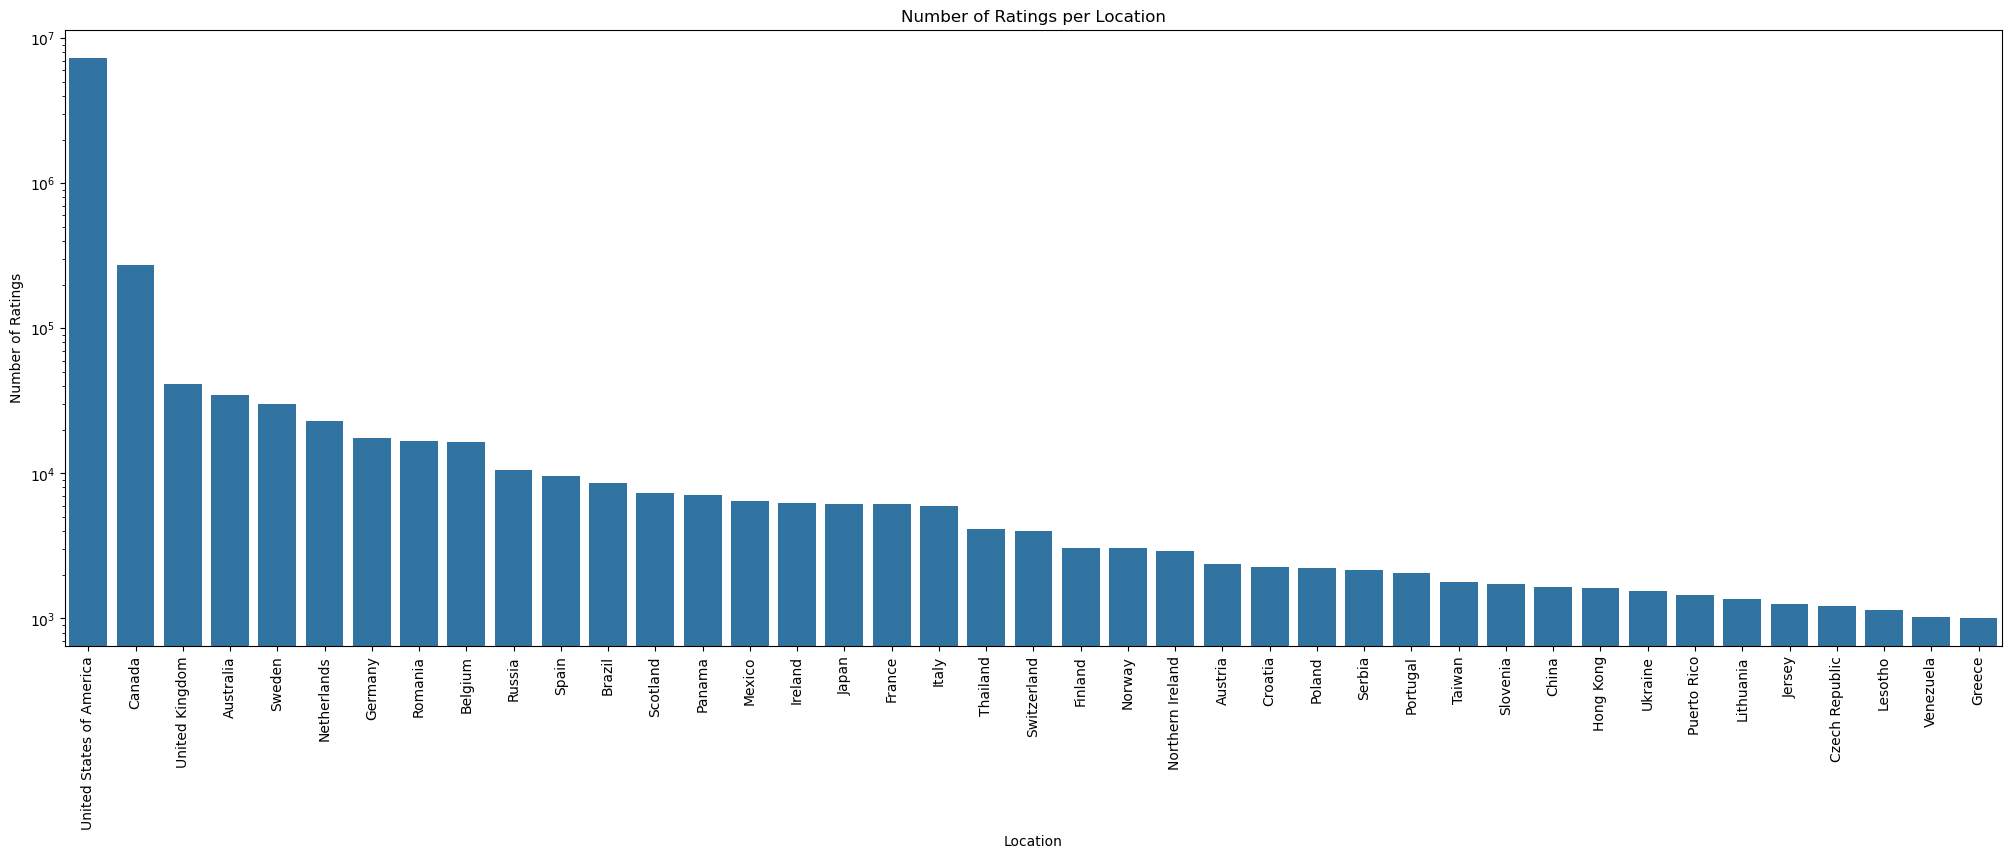

In [3]:
def clean_location(location):
    #The goal of this method is to change the name of some countries
    #to be able to use them on the shapefile
    if isinstance(location, str):  # Check if location is a string
        country = location.split(',')[0].strip()
        # Replace "United States" with "United States of America"
        if country == "United States":
            return "United States of America"
        if country == "England":
            return "United Kingdom"
        return country
    return None

# Apply the cleanup function
ba_users_df['cleaned_location'] = ba_users_df['location'].apply(clean_location)
#Compute the number of ratings per location
nbr_ratings_per_location = ba_users_df.groupby('cleaned_location')['nbr_ratings'].sum().reset_index()
#Keep only the location where there were more than 1000 ratings
nbr_ratings_per_location = nbr_ratings_per_location[nbr_ratings_per_location['nbr_ratings'] > 1000].sort_values(by='nbr_ratings', ascending=False)

print(nbr_ratings_per_location.head(10))
plt.figure(figsize=(25, 8))
sns.barplot(data=nbr_ratings_per_location, x='cleaned_location', y='nbr_ratings', log=True)
plt.title('Number of Ratings per Location')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)  # Rotate location names vertically
plt.show()

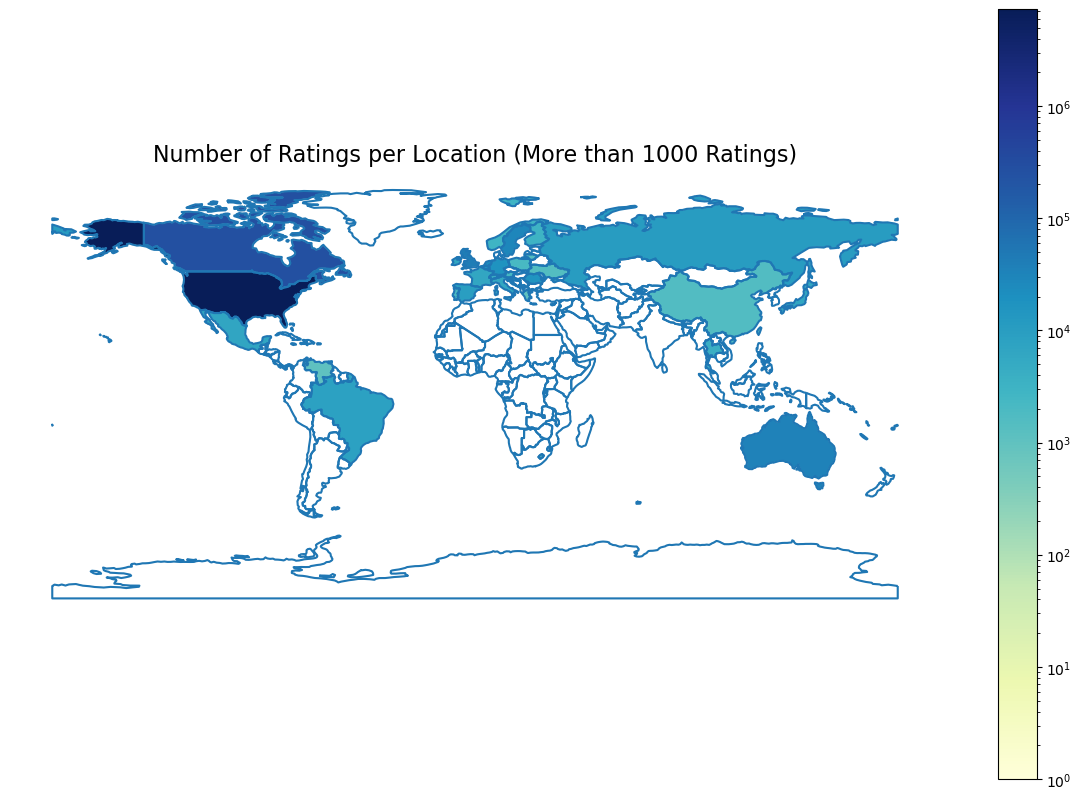

In [4]:
shapefile_path = r'C:\Users\Qrnqult\OneDrive\Documents\GitHub\ada-2024-project-data-crusadas\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Merge your ratings data with the world GeoDataFrame
merged = world.merge(nbr_ratings_per_location, how='left', left_on='SOVEREIGNT', right_on='cleaned_location')

# Fill NaN values in 'nbr_ratings' with 0 for visualization
merged['nbr_ratings'] = merged['nbr_ratings'].fillna(0)

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax)  # Plot the world boundaries
merged.plot(column='nbr_ratings', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', 
            norm=LogNorm(vmin=1, vmax=merged['nbr_ratings'].max()), legend=True)

# Customizing the plot
ax.set_title('Number of Ratings per Location (More than 1000 Ratings)', fontsize=16)
ax.set_axis_off()  # Turn off the axis
plt.show()

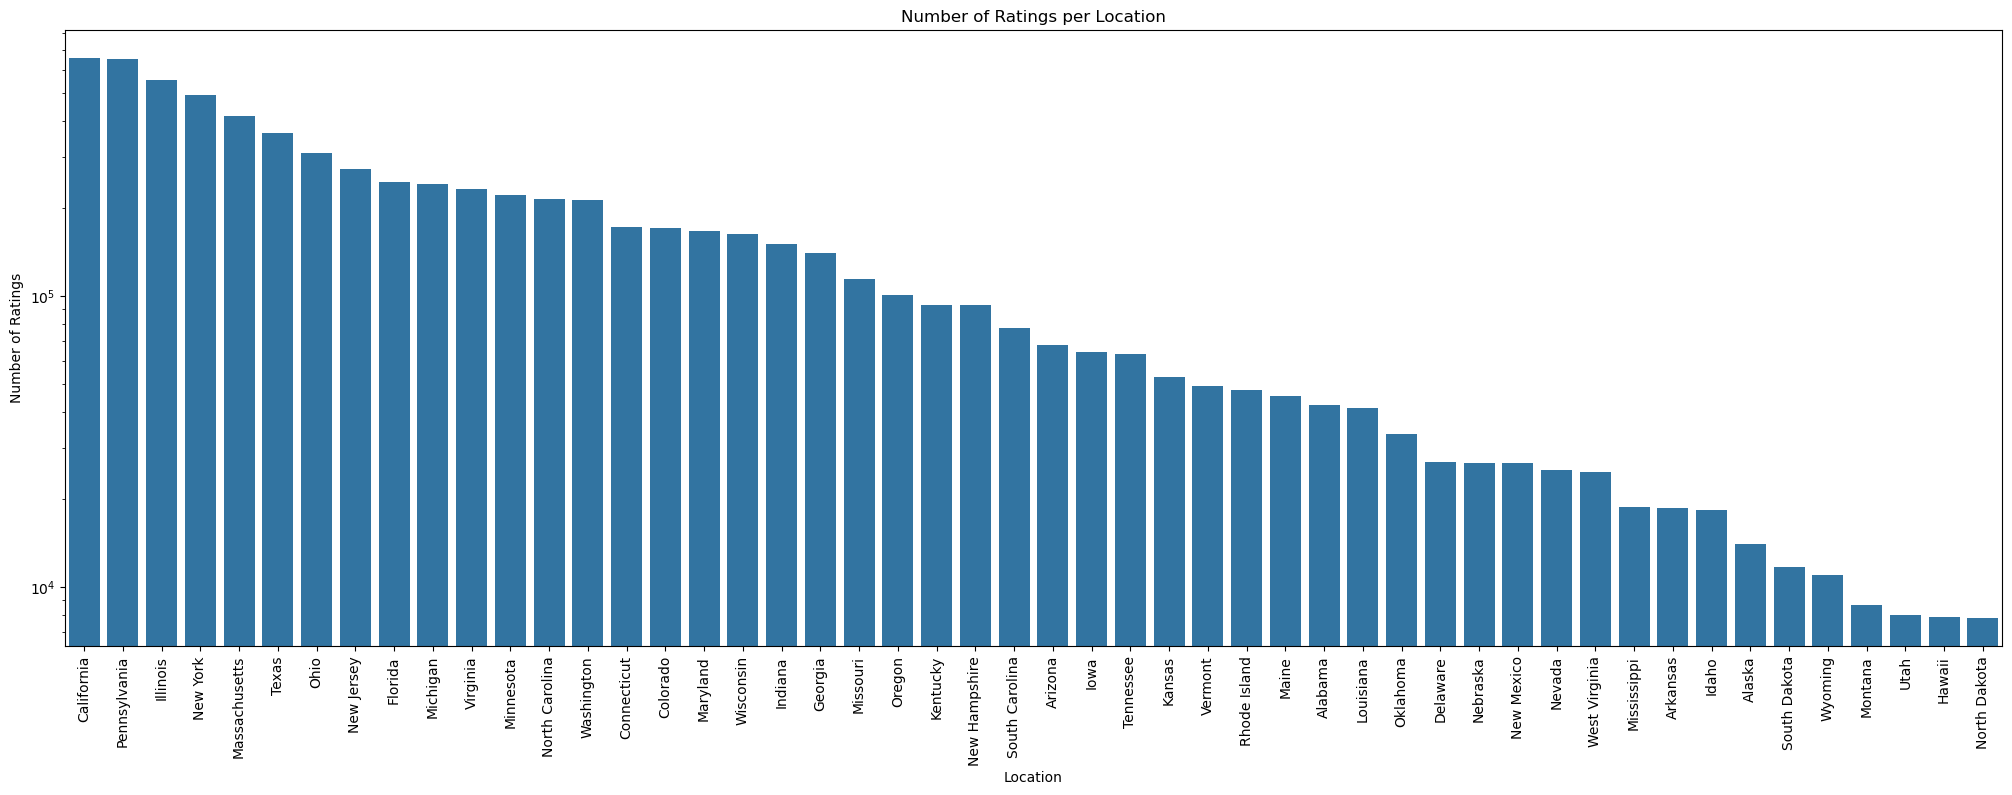

In [8]:
def clean_states(location):
    # This function will clean the location string by extracting the last part (state or city)
    if isinstance(location, str):  # Check if location is a string
        # Split the location by commas and strip whitespace
        parts = location.split(',')
        # Return the last part, which should be the state or city
        return parts[-1].strip() if parts else None
    return None

# Apply the cleanup function
us_states_df = ba_users_df[ba_users_df['location'].str.startswith("United States", na=False)].copy()
us_states_df['states'] = us_states_df['location'].apply(clean_states)
#Compute the number of ratings per location
nbr_ratings_per_location = us_states_df.groupby('states')['nbr_ratings'].sum().reset_index()
#Keep only the location where there were more than 1000 ratings
nbr_ratings_per_location = nbr_ratings_per_location[nbr_ratings_per_location['nbr_ratings'] > 200].sort_values(by='nbr_ratings', ascending=False)

plt.figure(figsize=(25, 8))
sns.barplot(data=nbr_ratings_per_location, x='states', y='nbr_ratings', log=True)
plt.title('Number of Ratings per Location')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)  # Rotate location names vertically
plt.show()

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'GEOIDFQ',
       'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


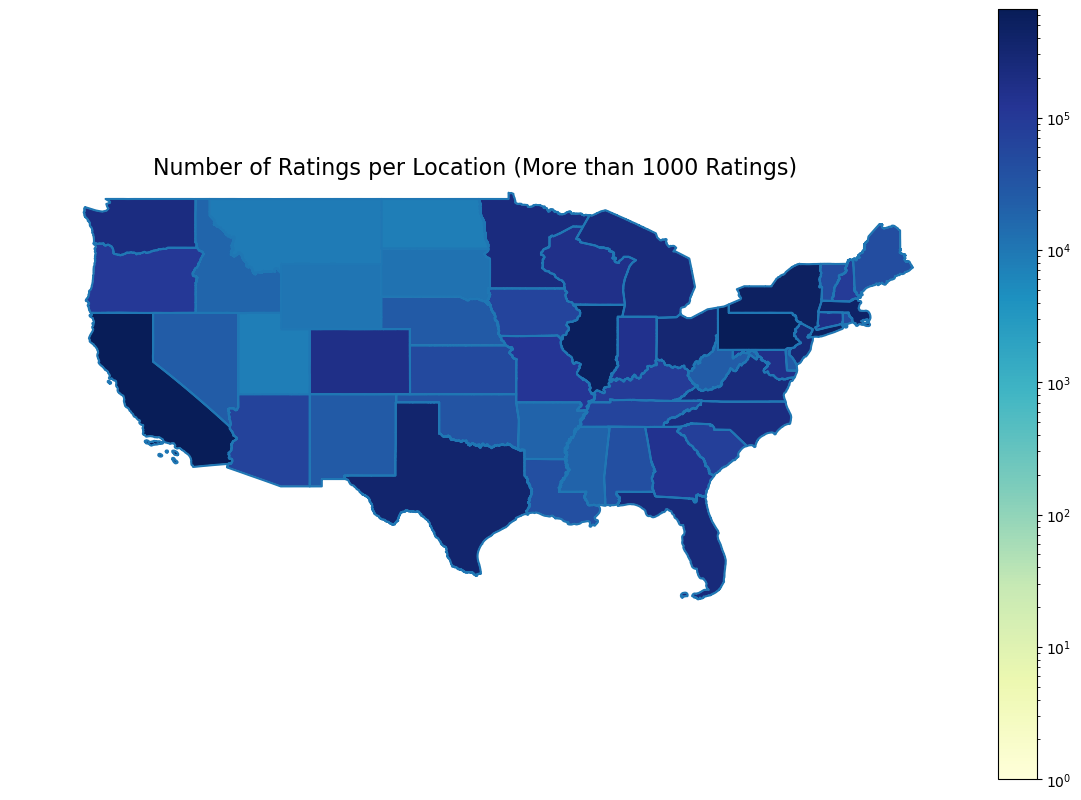

In [92]:
shapefile_path = r'C:\Users\Qrnqult\OneDrive\Documents\GitHub\ada-2024-project-data-crusadas\tl_2024_us_state\tl_2024_us_state.shp'
us = gpd.read_file(shapefile_path)
print(us.columns)

# Merge your ratings data with the world GeoDataFrame
merged = us.merge(nbr_ratings_per_location, how='left', left_on='NAME', right_on='states')

# Fill NaN values in 'nbr_ratings' with 0 for visualization
merged['nbr_ratings'] = merged['nbr_ratings'].fillna(0)

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax)  # Plot the world boundaries
merged.plot(column='nbr_ratings', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', 
            norm=LogNorm(vmin=1, vmax=merged['nbr_ratings'].max()), legend=True)

# Customizing the plot
ax.set_title('Number of Ratings per Location (More than 1000 Ratings)', fontsize=16)
ax.set_xlim([-130, -65])  # x-limits (longitude) for US (adjust for specific areas)
ax.set_ylim([24, 50])
ax.set_axis_off()  # Turn off the axis
plt.show()

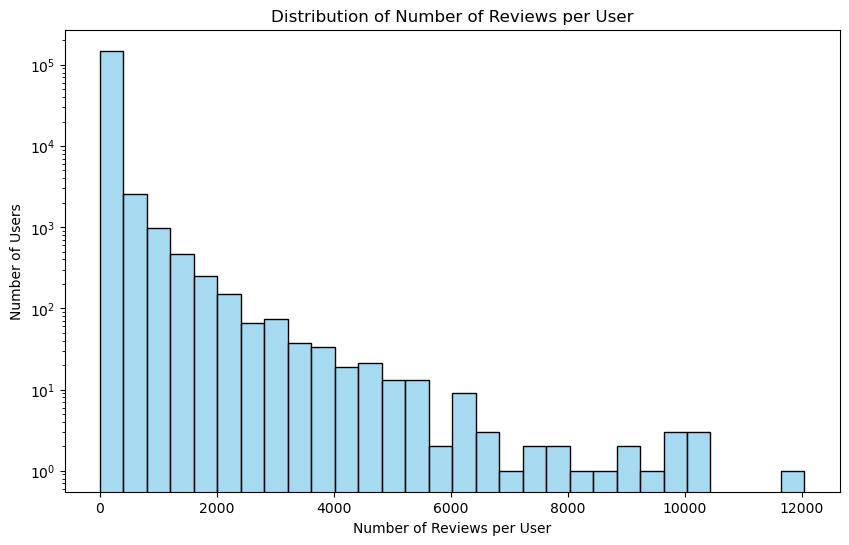

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(ba_users_df['nbr_ratings'], bins=30, kde=False, color="skyblue")  # Adjust bins as needed
plt.xlabel('Number of Reviews per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Reviews per User')
plt.yscale('log')  # Optional: Log scale for better visualization if skewed
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\96069282.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_counts.values, y=style_counts.index, palette="viridis")


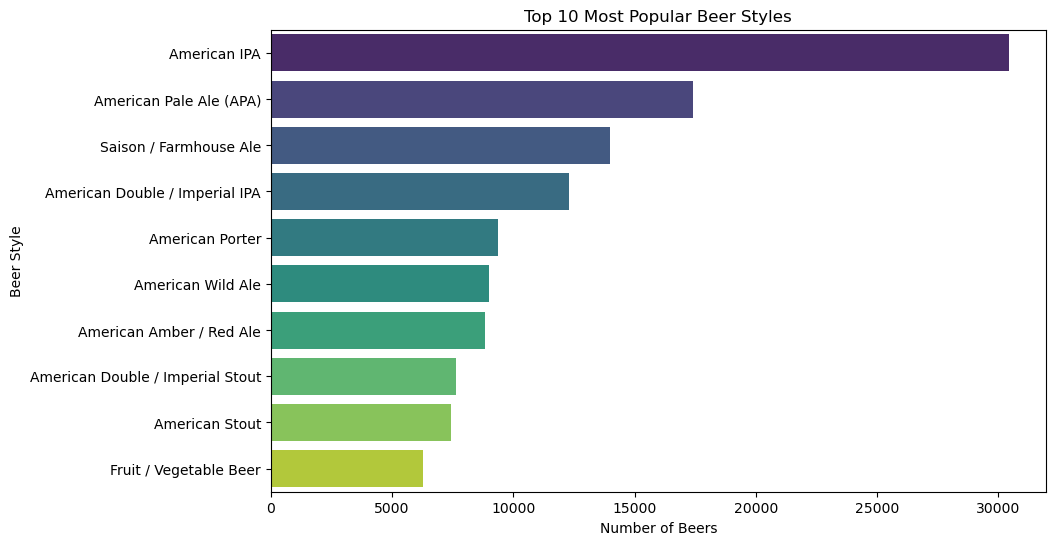

In [ ]:
style_counts = ba_beers_df['style'].value_counts().head(10)  # Top 10 beer styles

plt.figure(figsize=(10,6))
sns.barplot(x=style_counts.values, y=style_counts.index, palette="viridis")
plt.title("Top 10 Most Popular Beer Styles")
plt.xlabel("Number of Beers")
plt.ylabel("Beer Style")
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\1821390559.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_counts_ratings, y=style_counts_ratings.index.tolist(), palette="viridis")


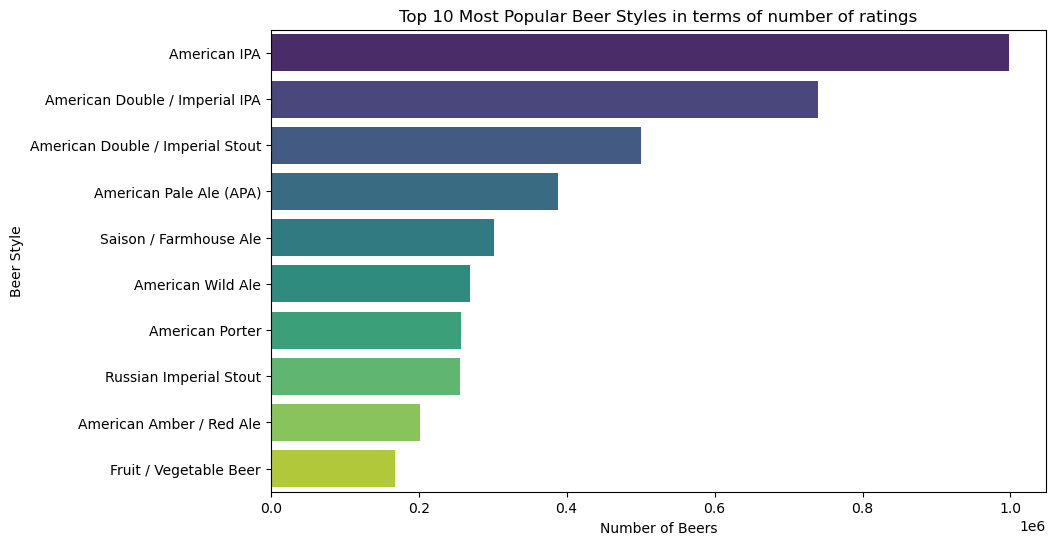

In [106]:
style_counts_ratings = ba_ratings_df['style'].dropna().value_counts().sort_values(ascending=False).head(10)  # Top 10 beer styles

plt.figure(figsize=(10,6))
sns.barplot(x=style_counts_ratings, y=style_counts_ratings.index.tolist(), palette="viridis")
plt.title("Top 10 Most Popular Beer Styles in terms of number of ratings")
plt.xlabel("Number of Beers")
plt.ylabel("Beer Style")
plt.show()

**Most drinken beer per location and per year**

Here we merge to have the useful values

In [420]:
users_df_selected = ba_users_df[['user_id', 'location']]
ratings_df_selected = ba_ratings_df[['user_id', 'brewery_id', 'style', 'abv', 'appearance', 'aroma', 'palate', 'rating', 'taste', 'date']]

# Merging on 'user_id'
#Contains the ratings and the location of the users
merged_df = pd.merge(users_df_selected, ratings_df_selected, on='user_id', how='right')

ba_breweries_df.rename(columns={'location': 'brewery_location'}, inplace=True)
ba_breweries_df.rename(columns={'id': 'brewery_id'}, inplace=True)

ba_breweries_selected = ba_breweries_df[['brewery_id', 'brewery_location', 'nbr_beers']]

# Perform the merge on `beer_id`
#Contains the ratings, the location of the users and the location of the breweries
final_merged_df = pd.merge(merged_df, ba_breweries_selected, on='brewery_id', how='inner')
#[8393032 rows x 11 columns]

In [421]:
# Assuming final_merged_df is your DataFrame
# Get unique styles from the 'style' column
unique_styles = final_merged_df['style'].unique()

# Print the unique styles
print(unique_styles)

['Euro Pale Lager', 'English Pale Ale', 'English Bitter', 'American Pale Wheat Ale', 'American Blonde Ale', ..., 'Lambic - Unblended', 'Bière de Champagne / Bière Brut', 'Japanese Rice Lager', 'Happoshu', 'Faro']
Length: 104
Categories (104, object): ['Altbier', 'American Amber / Red Ale', 'American Amber / Red Lager', 'American Barleywine', ..., 'Lambic - Unblended', 'Happoshu', 'Japanese Rice Lager', 'Faro']


In [422]:
macro_group = {
    'IPA': ['American IPA', 'English India Pale Ale (IPA)', 'Belgian IPA', 'American Double / Imperial IPA']
}

In [423]:
final_merged_df['datetime'] = pd.to_datetime(final_merged_df['date'], unit='s')

# Extract the year from the datetime
final_merged_df['year'] = final_merged_df['datetime'].dt.year
# Extract the month from the datetime
final_merged_df['month'] = final_merged_df['datetime'].dt.month
#Delete unused columns
final_merged_df = final_merged_df.drop('datetime', axis=1)
final_merged_df = final_merged_df.drop('date', axis=1)

def categorize_macro_group(style):
    for key, styles in macro_group.items():
        if style in styles:
            return key
    return 'Other'

final_merged_df['macro_group'] = final_merged_df['style'].apply(categorize_macro_group)

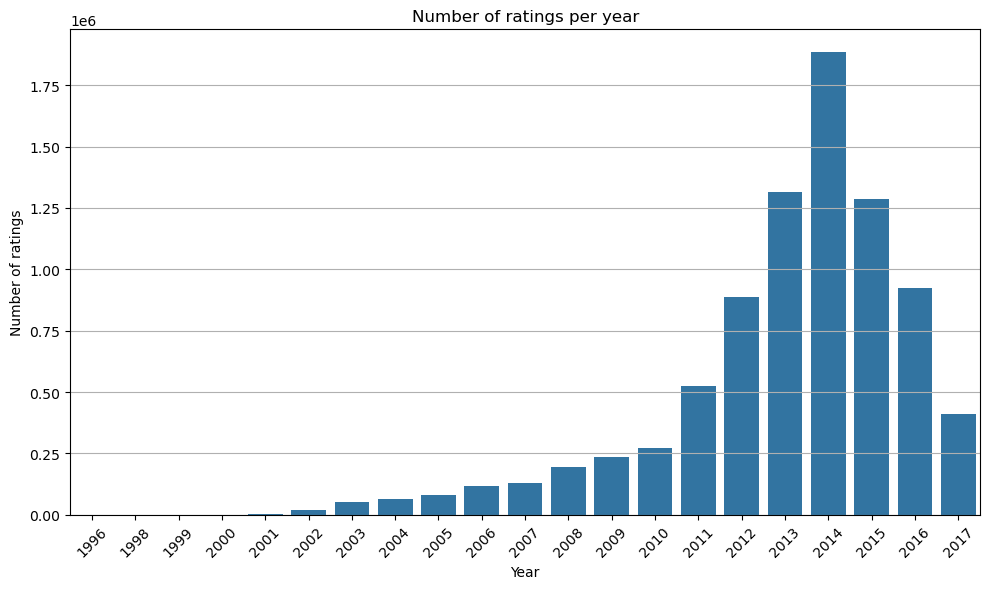

In [424]:
per_year = final_merged_df.groupby(['year']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=per_year, x='year', y='count')
plt.title('Number of ratings per year')
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


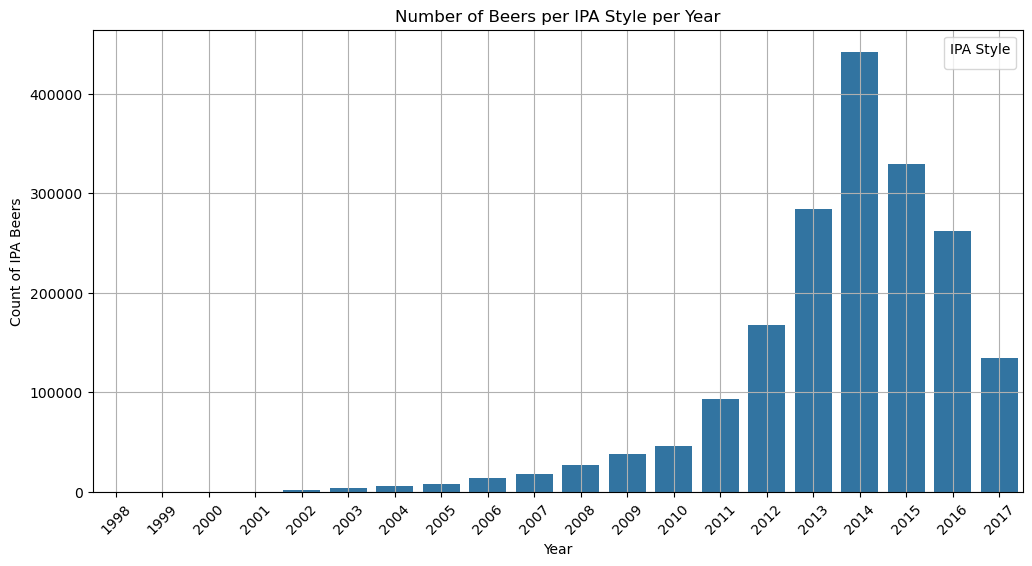

In [246]:
per_year_IPA_total = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=per_year_IPA_total, x='year', y='count')

# Customize the plot
plt.title('Number of Beers per IPA Style per Year')
plt.xlabel('Year')
plt.ylabel('Count of IPA Beers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='IPA Style')  # Add a legend to differentiate IPA styles
plt.grid(True)
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\3881277126.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_year_IPA = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year', 'style']).size().reset_index(name='count')


                                year  count
style                                      
American IPA                    1998      5
English India Pale Ale (IPA)    1998      5
American IPA                    1999      5
English India Pale Ale (IPA)    1999      1
American Double / Imperial IPA  2000      1
...                              ...    ...
English India Pale Ale (IPA)    2016   4493
American Double / Imperial IPA  2017  54539
American IPA                    2017  75585
Belgian IPA                     2017   2005
English India Pale Ale (IPA)    2017   1800

[75 rows x 2 columns]


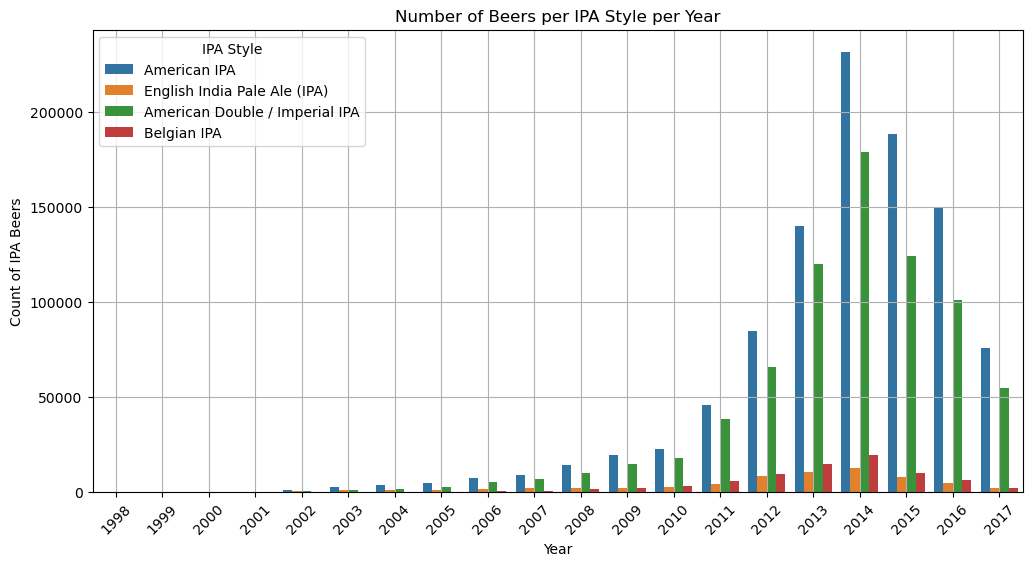

In [247]:
# Group by 'year' and 'macro_group' (IPA style) and count occurrences
per_year_IPA = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year', 'style']).size().reset_index(name='count')
per_year_IPA = per_year_IPA[(per_year_IPA['count'] > 0)]
per_year_IPA = per_year_IPA.set_index('style')
print(per_year_IPA)

# Plotting the data with one bar per IPA style for each year
plt.figure(figsize=(12, 6))
sns.barplot(data=per_year_IPA, x='year', y='count', hue=per_year_IPA.index.tolist())

# Customize the plot
plt.title('Number of Beers per IPA Style per Year')
plt.xlabel('Year')
plt.ylabel('Count of IPA Beers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='IPA Style')  # Add a legend to differentiate IPA styles
plt.grid(True)
plt.show()


In [425]:
#We decided to keep only the years after 2007 for our analysis over the years:
final_merged_df = final_merged_df[final_merged_df['year'] >= 2008]

In [394]:
#Here we compute the percentage of beer beeing IPA per year

grouped = final_merged_df.groupby(['year', 'macro_group']).size().reset_index(name='count')

# Group by year to get total counts
total_count_per_year = final_merged_df.groupby('year').size().reset_index(name='total_count')

# Merge the counts with total counts
merged = pd.merge(grouped, total_count_per_year, on='year')

# Calculate the percentage
merged['percentage'] = (merged['count'] / merged['total_count']) * 100

# Filter to show only the macro group 'IPA'
result = merged[merged['macro_group'] == 'IPA'][['year', 'count', 'total_count', 'percentage']]

print(result)

    year   count  total_count  percentage
0   2008   27043       194854   13.878596
2   2009   37902       233253   16.249309
4   2010   46022       270984   16.983291
6   2011   93404       524259   17.816385
8   2012  167917       888491   18.899122
10  2013  284377      1314109   21.640290
12  2014  442169      1883572   23.475025
14  2015  329802      1286137   25.642836
16  2016  261647       924219   28.310065
18  2017  133929       412415   32.474328


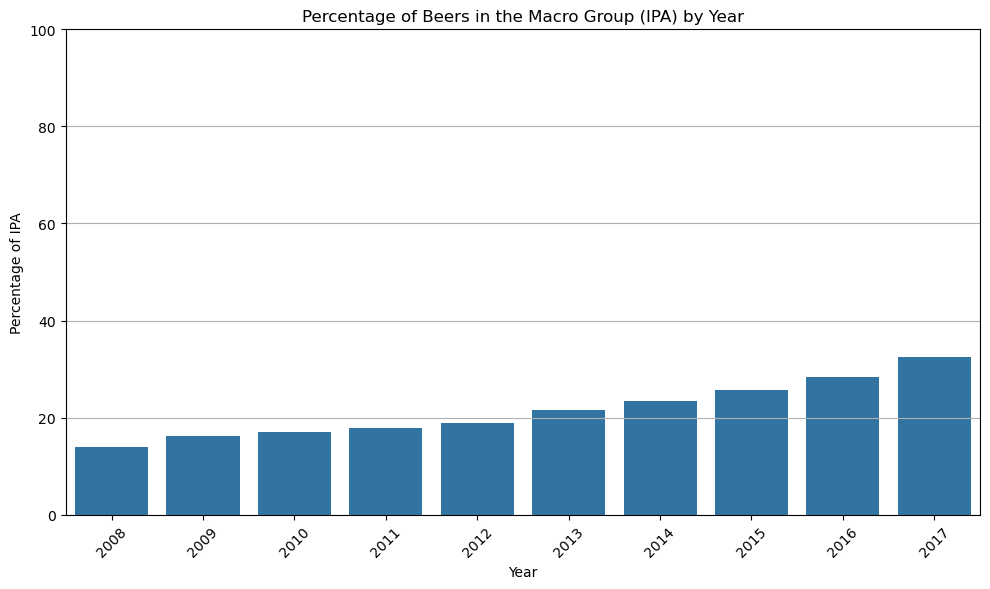

In [251]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result, x='year', y='percentage')
plt.title('Percentage of Beers in the Macro Group (IPA) by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of IPA')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y')  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

**IPA in top 3**

In [332]:
def filter_location(min_ratings, final_merged_df):
    location_ratings = final_merged_df.groupby('location').count()

    # Filter locations with more than 1000 ratings
    locations_over_min = location_ratings[location_ratings['rating'] > min_ratings].index

    # Filter the original DataFrame to include only these locations
    return final_merged_df[final_merged_df['location'].isin(locations_over_min)]

location_df = filter_location(1000, final_merged_df)
beer_counts = location_df.groupby(['location', 'year', 'style']).size().reset_index(name='count')
print(beer_counts)

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\4175686313.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beer_counts = location_df.groupby(['location', 'year', 'style']).size().reset_index(name='count')


        location  year                            style  count
0      Australia  2008                          Altbier      5
1      Australia  2008         American Amber / Red Ale     17
2      Australia  2008       American Amber / Red Lager      0
3      Australia  2008              American Barleywine      4
4      Australia  2008               American Black Ale      0
...          ...   ...                              ...    ...
93595  Venezuela  2017  Bière de Champagne / Bière Brut      0
93596  Venezuela  2017               Lambic - Unblended      0
93597  Venezuela  2017                         Happoshu      0
93598  Venezuela  2017              Japanese Rice Lager      0
93599  Venezuela  2017                             Faro      0

[93600 rows x 4 columns]


In [261]:
#For each year and location, give a rank for each beer styles. For example if Altbier has the most ratings for 2006 in Australia,
#we assign it as rank 1
beer_counts['rank'] = beer_counts.groupby(['location', 'year'])['count'].rank(method='first', ascending=False)

In [ ]:
#For each year and location, it gives the most rated beer
top_styles = beer_counts[beer_counts['rank'] <= 1]

# Sort the result for easier readability
#This gives the top beers per year and per location
top_styles = top_styles.sort_values(['location', 'year', 'rank'])

In [266]:
print(top_styles)

        location  year                    style  count  rank
37     Australia  2008         English Pale Ale     67   1.0
141    Australia  2009         English Pale Ale    154   1.0
218    Australia  2010             American IPA    219   1.0
322    Australia  2011             American IPA    351   1.0
426    Australia  2012             American IPA    392   1.0
...          ...   ...                      ...    ...   ...
93101  Venezuela  2013  Belgian Strong Pale Ale      2   1.0
93184  Venezuela  2014                  Altbier      0   1.0
93298  Venezuela  2015             American IPA     12   1.0
93402  Venezuela  2016             American IPA     97   1.0
93508  Venezuela  2017      American Pale Lager      3   1.0

[900 rows x 5 columns]


In [ ]:
#is_IPA is true if for a given location and given year, the best beer is an IPA
top_styles['is_IPA'] = top_styles['style'].isin(macro_group['IPA'])

# For each year and location, check if there's an IPA style
ipa_presence = (
    top_styles.groupby(['location', 'year'])['is_IPA']
    .any()  # Check if there's any IPA style in each group  # Replace True/False with Yes/No
    .reset_index(name='IPA_Present')  # Reset index and name the column
)

In [269]:
print(ipa_presence)

      location  year  IPA_Present
0    Australia  2008        False
1    Australia  2009        False
2    Australia  2010         True
3    Australia  2011         True
4    Australia  2012         True
..         ...   ...          ...
895  Venezuela  2013        False
896  Venezuela  2014        False
897  Venezuela  2015         True
898  Venezuela  2016         True
899  Venezuela  2017        False

[900 rows x 3 columns]


In [291]:
def compute_best_countries_per_year(ipa_presence):

    #Check if for all countries the 10 years range is present
    check_countries = ipa_presence.groupby('location').count().reset_index()
    print(check_countries[check_countries['year'] < 10])

    #Print the total number of countries
    total_countries = ipa_presence['location'].nunique()
    print("Total number of countries: ", total_countries)

    # Filter for rows where IPA_Present is "Yes"
    ipa_countries = ipa_presence[ipa_presence['IPA_Present'] == True]

    # Group by year and count unique locations
    #This gives the number of countries that have as the best beer beeing an IPA per year
    ipa_presence_count = ipa_countries.groupby('year')['location'].nunique().reset_index(name='num_countries_with_IPA')

    # Display the result
    print(ipa_presence_count)

    return ipa_presence_count, total_countries, 

ipa_presence_count, total_countries = compute_best_countries_per_year(ipa_presence)

Empty DataFrame
Columns: [location, year, IPA_Present]
Index: []
Total number of countries:  90
   year  num_countries_with_IPA
0  2008                      51
1  2009                      53
2  2010                      51
3  2011                      60
4  2012                      62
5  2013                      67
6  2014                      71
7  2015                      82
8  2016                      83
9  2017                      84


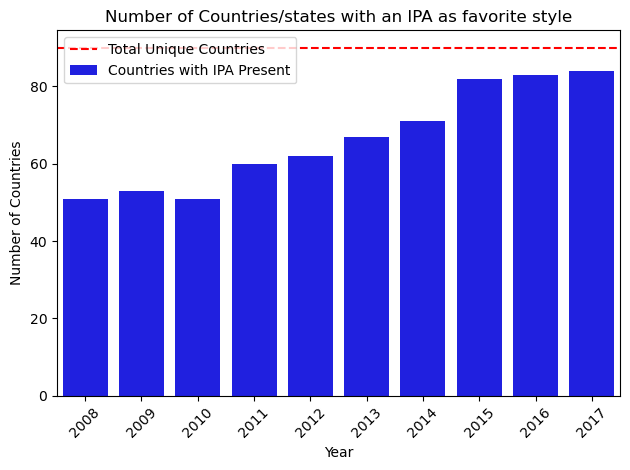

In [292]:
# Bar plot for the number of countries with IPA
sns.barplot(x='year', y='num_countries_with_IPA', data=ipa_presence_count, color='blue', label='Countries with IPA Present')

# Adding a line plot for total countries (this will be a constant line across years)
plt.axhline(y=total_countries, color='red', linestyle='--', label='Total Unique Countries')

# Customize the plot
plt.title('Number of Countries/states with an IPA as favorite style')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

**How envolve the ratings over year?**

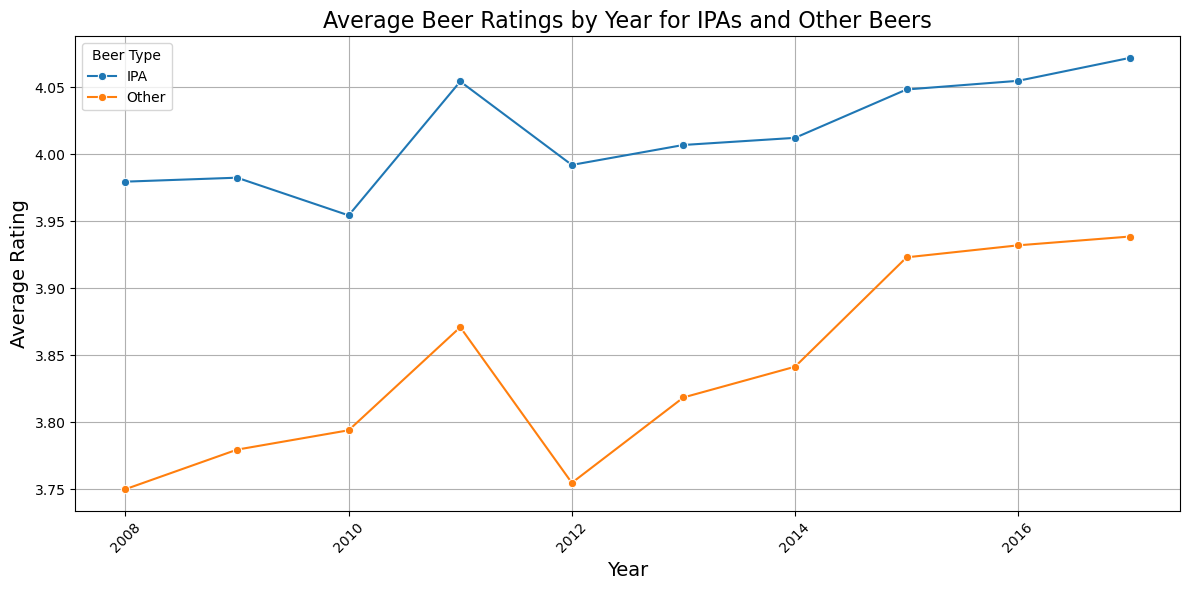

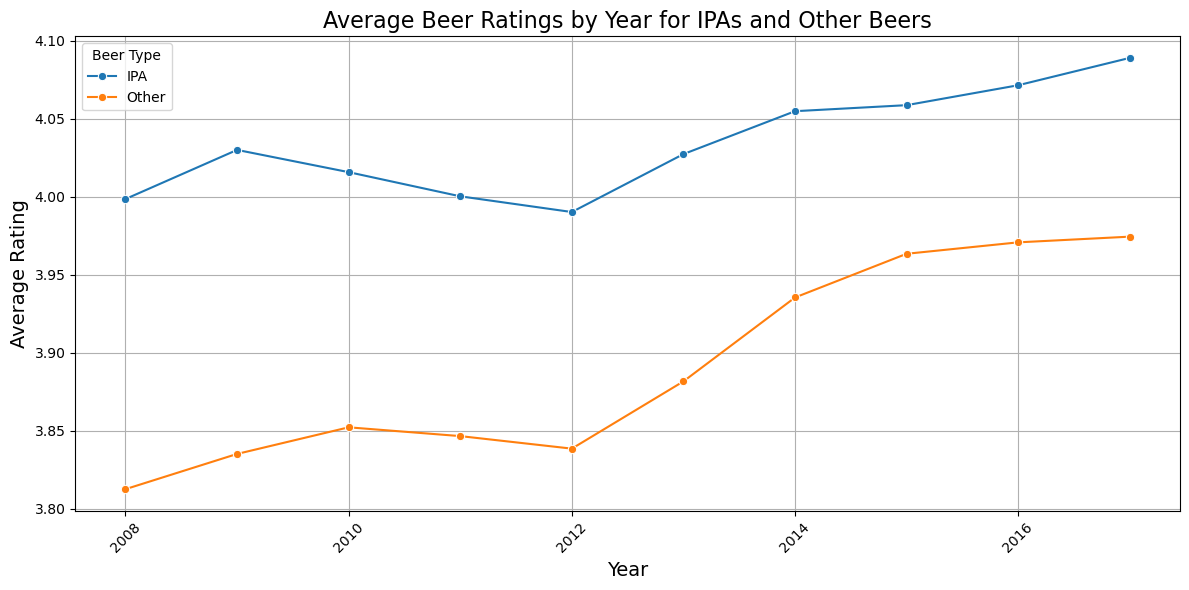

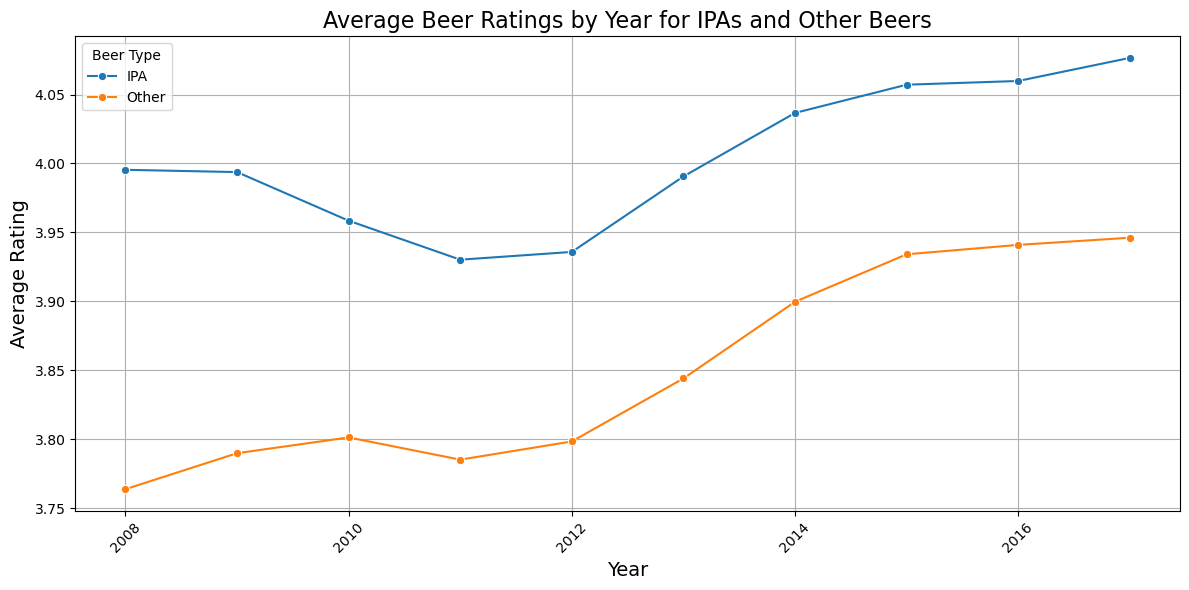

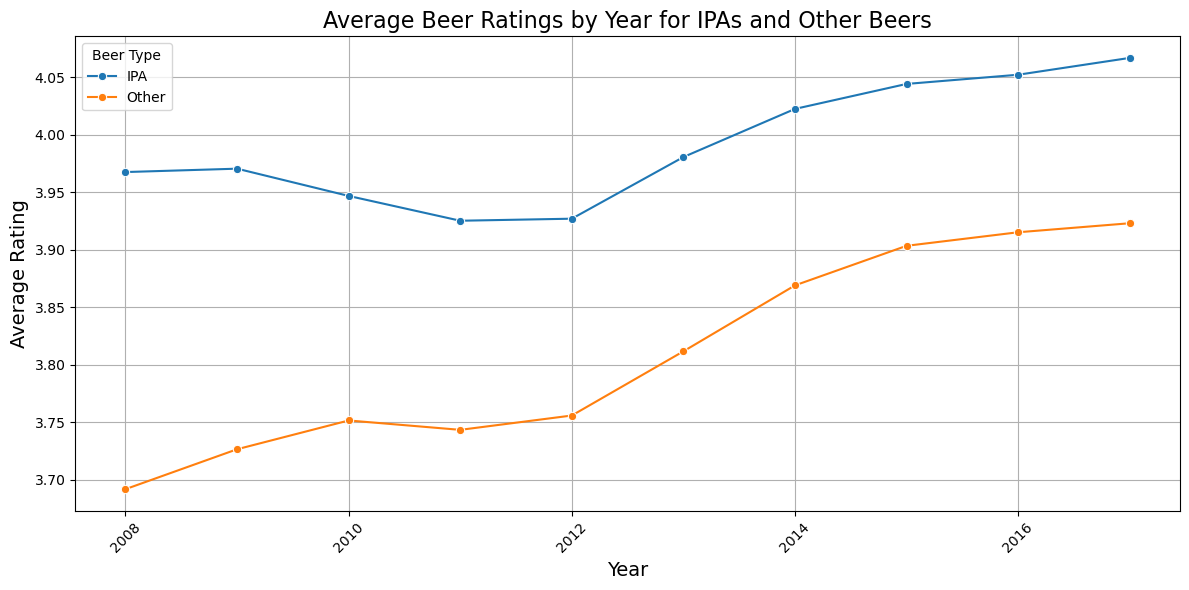

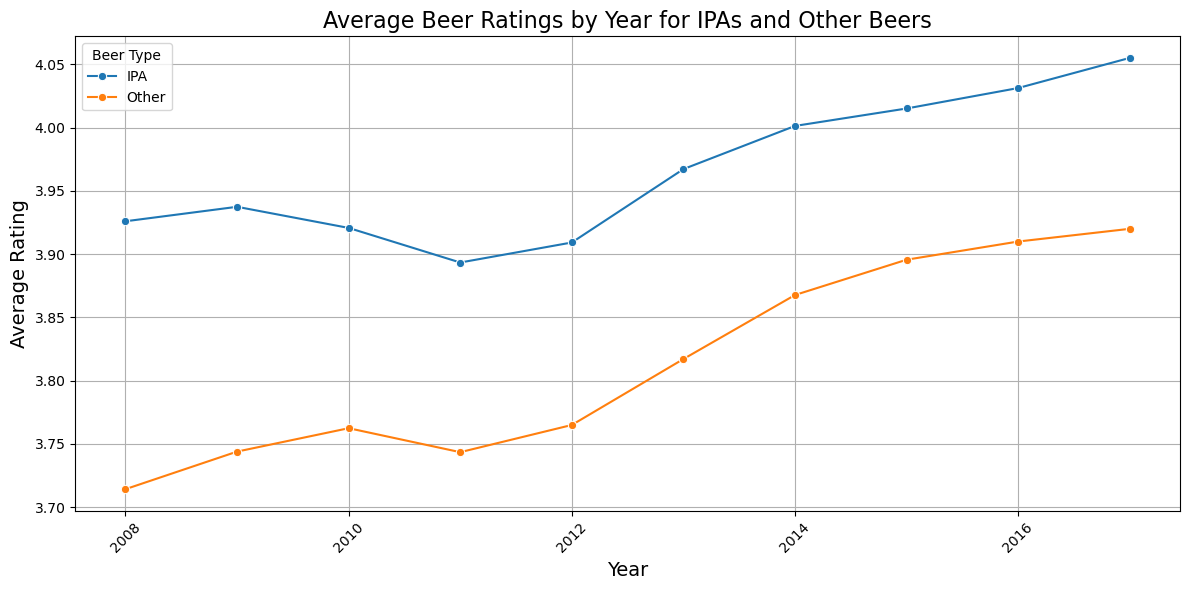

In [429]:
def envolve_rating(rating_kind):
    average_ratings = final_merged_df.groupby(['year', 'macro_group'])[rating_kind].mean().reset_index()
    average_ratings.rename(columns={rating_kind: 'average_rating'}, inplace=True)
    #print(average_ratings)
    plt.figure(figsize=(12, 6))

    # Create a line plot for average ratings
    sns.lineplot(data=average_ratings, x='year', y='average_rating', hue='macro_group', marker='o')

    # Customize the plot
    plt.title('Average Beer Ratings by Year for IPAs and Other Beers', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Rating', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='Beer Type')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()
#apperance, taste, aroma, palate, rating
envolve_rating('rating')
envolve_rating('appearance')
envolve_rating('taste')
envolve_rating('aroma')
envolve_rating('palate')

**Is that true that every country rates better IPAs than other beers?**

In [333]:
filtered_df = filter_location(5000, final_merged_df)
average_ratings = filtered_df.groupby(['location', 'macro_group'])['rating'].mean().reset_index()

print(average_ratings)

                         location macro_group    rating
0                       Australia         IPA  3.856444
1                       Australia       Other  3.598798
2                         Belgium         IPA  3.834279
3                         Belgium       Other  3.699286
4                          Brazil         IPA  3.932266
..                            ...         ...       ...
129  United States, West Virginia       Other  3.820085
130      United States, Wisconsin         IPA  4.046598
131      United States, Wisconsin       Other  3.888162
132        United States, Wyoming         IPA  3.961343
133        United States, Wyoming       Other  3.788739

[134 rows x 3 columns]


C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\623373294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_states['states'] = american_states['location'].apply(clean_states)


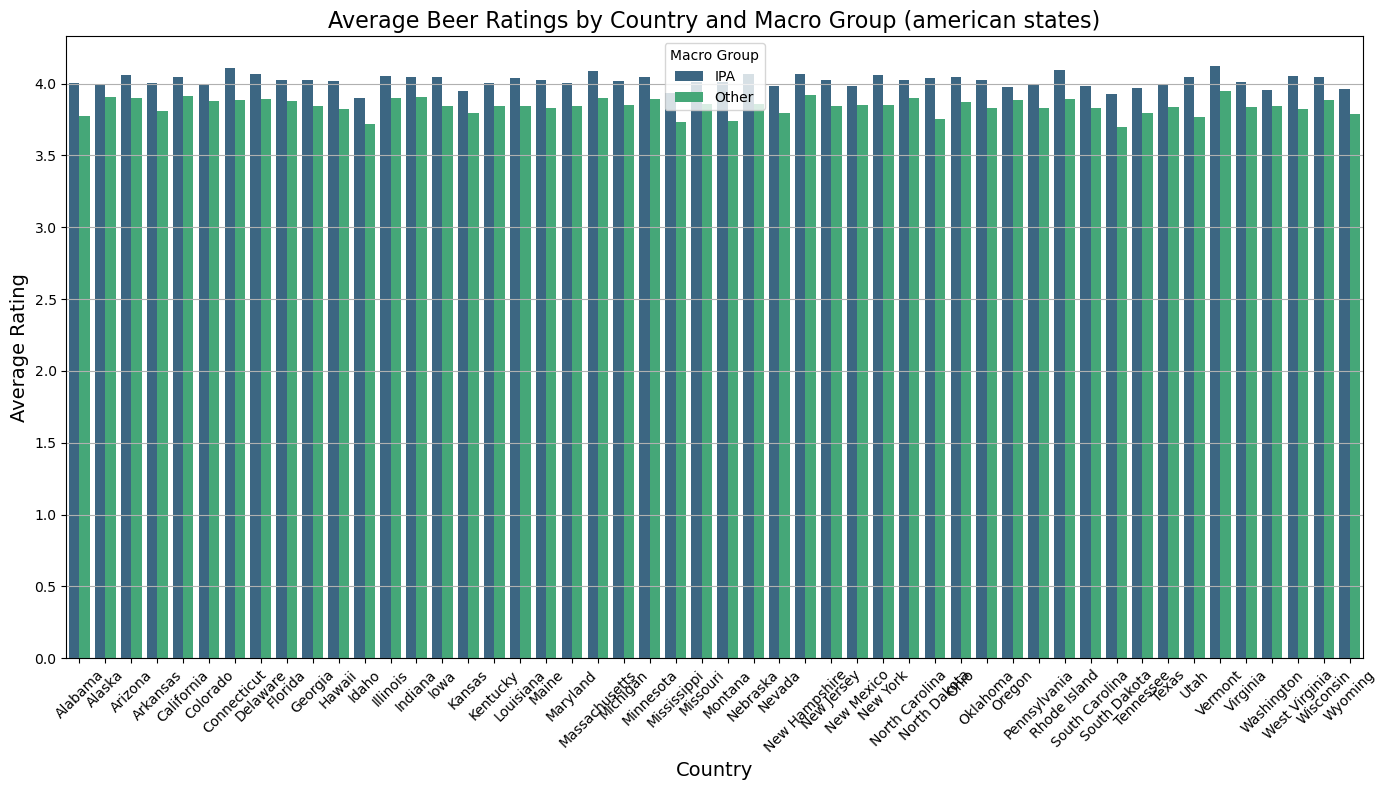

In [342]:
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

american_states = average_ratings[average_ratings['location'].str.startswith("United States")]
non_american_states = average_ratings[~average_ratings['location'].str.startswith("United States")]

american_states['states'] = american_states['location'].apply(clean_states)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(data=american_states, x='states', y='average_rating', hue='macro_group', palette='viridis')

# Customize the plot
plt.title('Average Beer Ratings by Country and Macro Group (american states)', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Macro Group')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

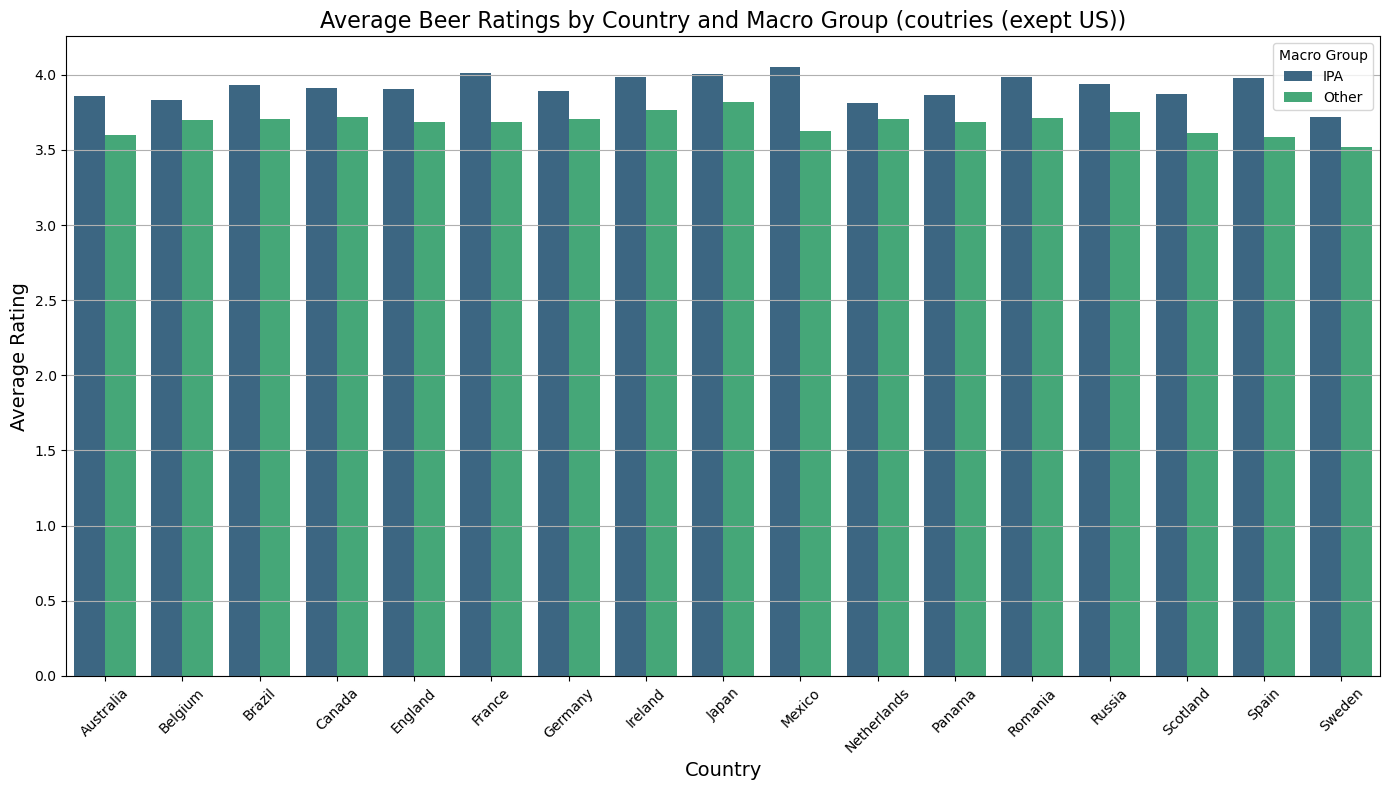

In [315]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(data=non_american_states, x='location', y='average_rating', hue='macro_group', palette='viridis')

# Customize the plot
plt.title('Average Beer Ratings by Country and Macro Group (coutries (exept US))', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Macro Group')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

**Let's investigate if the ratings of big or small raters are different**

In [317]:
user_rating_counts = final_merged_df.groupby('user_id')['rating'].count().reset_index()
user_rating_counts.columns = ['user_id', 'rating_count']  # Rename columns for clarity

In [318]:
print(user_rating_counts)

                       user_id  rating_count
0       -----kiki-----.1000245             2
1                   ---.940711             3
2             --dida--.1042029             3
3               --dom--.709199           165
4             --nomad--.931404             1
...                        ...           ...
151106      zzxasd43and.416381             1
151107       zzyskowski.807938             1
151108            zzyzx.174143             1
151109           zzz999.829367             1
151110         zzznumb.1062846             3

[151111 rows x 2 columns]


In [319]:
number_ratings = 500
users_above = user_rating_counts[user_rating_counts['rating_count'] > number_ratings]
users_below = user_rating_counts[user_rating_counts['rating_count'] <= number_ratings]

In [322]:
#Seperate the dataframe final_merged_df between big and small users
big_users = final_merged_df[final_merged_df['user_id'].isin(users_above['user_id'])]
small_users = final_merged_df[final_merged_df['user_id'].isin(users_below['user_id'])]

In [321]:
print(big_users.head())

          user_id                   location  brewery_id  \
0  nmann08.184925  United States, Washington       37262   
1  nmann08.184925  United States, Washington       13092   
2  nmann08.184925  United States, Washington         323   
3  nmann08.184925  United States, Washington         323   
4  nmann08.184925  United States, Washington         323   

                                 style  appearance  aroma  palate  rating  \
0                      Euro Pale Lager        3.25   2.75    3.25    2.88   
1  Extra Special / Strong Bitter (ESB)        4.00   3.50    3.75    3.56   
2                              Old Ale         NaN    NaN     NaN    4.50   
3                              Old Ale         NaN    NaN     NaN    3.75   
4                       English Porter        4.00   3.50    3.75    3.81   

   taste brewery_location  year  month macro_group  
0   2.75            Gabon  2015      8       Other  
1   3.50            Wales  2015     11       Other  
2    NaN         

In [323]:
#Compute the avg rating for IPA and Other for big and small users
big_avg_ratings = big_users.groupby('macro_group')['rating'].mean().reset_index()
small_avg_ratings = small_users.groupby('macro_group')['rating'].mean().reset_index()
avg_ratings = pd.merge(big_avg_ratings, small_avg_ratings, on='macro_group', suffixes=('_big', '_small'))
avg_ratings.columns = ['beer_type', 'big_users', 'small_users']

In [136]:
print(avg_ratings)

  beer_type  big_users  small_users
0       IPA   3.951862     4.101602
1     Other   3.813592     3.876678


  beer_type   user_group  average_rating
0       IPA    big_users        3.951986
1     Other    big_users        3.822330
2       IPA  small_users        4.103359
3     Other  small_users        3.885438


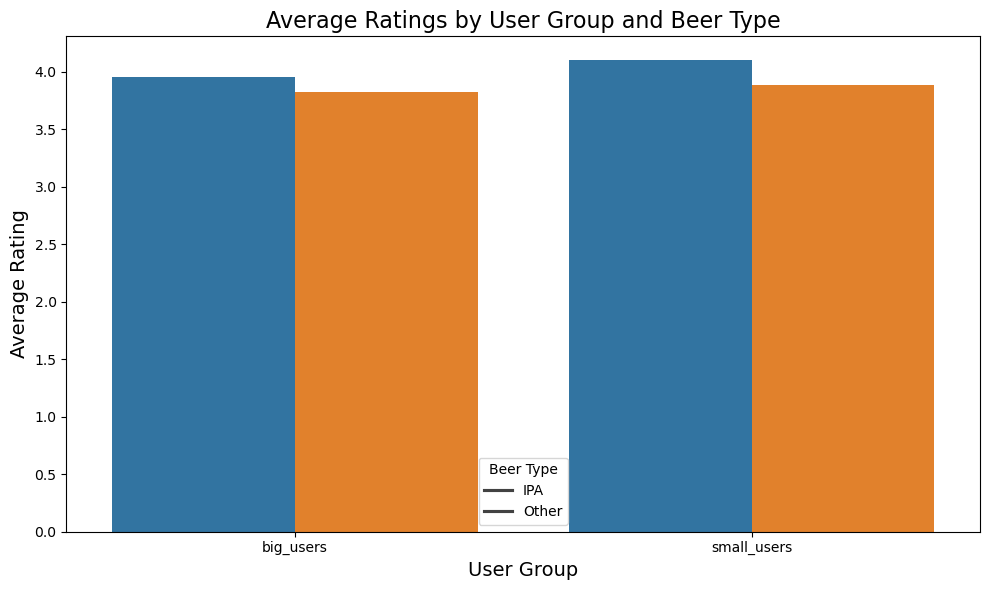

In [324]:
avg_ratings_melted = avg_ratings.melt(id_vars='beer_type', 
                                        value_vars=['big_users', 'small_users'],
                                        var_name='user_group', 
                                        value_name='average_rating')

print(avg_ratings_melted)

# Create a bar plot with user groups on the x-axis
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_ratings_melted, x='user_group', y='average_rating', hue='beer_type')

# Add titles and labels
plt.title('Average Ratings by User Group and Beer Type', fontsize=16)
plt.xlabel('User Group', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=0)  # No rotation needed for x-axis labels
plt.legend(title='Beer Type', labels=['IPA', 'Other'])
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()

In [327]:
print(len(users_above))
print(len(users_below))

3594
147517


**Let's investigate how the number of ratings change per location between IPA and other beers**

In [336]:
filtered_df_copy = filter_location(5000, final_merged_df).copy()
filtered_df_copy['is_IPA'] = filtered_df_copy['style'].isin(macro_group['IPA'])

In [337]:
location_ipa_percentage = filtered_df_copy.groupby('location').agg(
    IPA_Percentage=('is_IPA', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

# Display the result
print(location_ipa_percentage)
location_ipa_percentage_sorted = location_ipa_percentage.sort_values(by='IPA_Percentage', ascending=False)

                        location  IPA_Percentage
0                      Australia       15.651052
1                        Belgium       10.611038
2                         Brazil       17.222617
3                         Canada       18.620914
4                        England       15.634765
..                           ...             ...
62       United States, Virginia       24.276023
63     United States, Washington       23.038713
64  United States, West Virginia       21.337075
65      United States, Wisconsin       20.593885
66        United States, Wyoming       19.356703

[67 rows x 2 columns]


In [338]:
american_states = location_ipa_percentage_sorted[location_ipa_percentage_sorted['location'].str.startswith("United States")]
non_american_states = location_ipa_percentage_sorted[~location_ipa_percentage_sorted['location'].str.startswith("United States")]

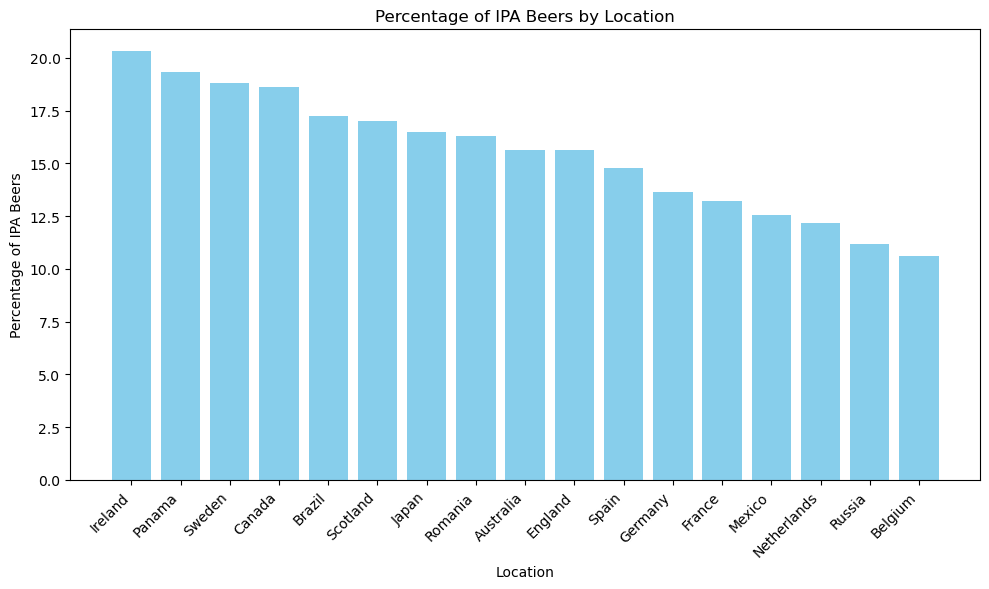

In [339]:
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(non_american_states['location'], non_american_states['IPA_Percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage of IPA Beers')
plt.title('Percentage of IPA Beers by Location')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\1220279976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_states['states'] = american_states['location'].apply(clean_states)


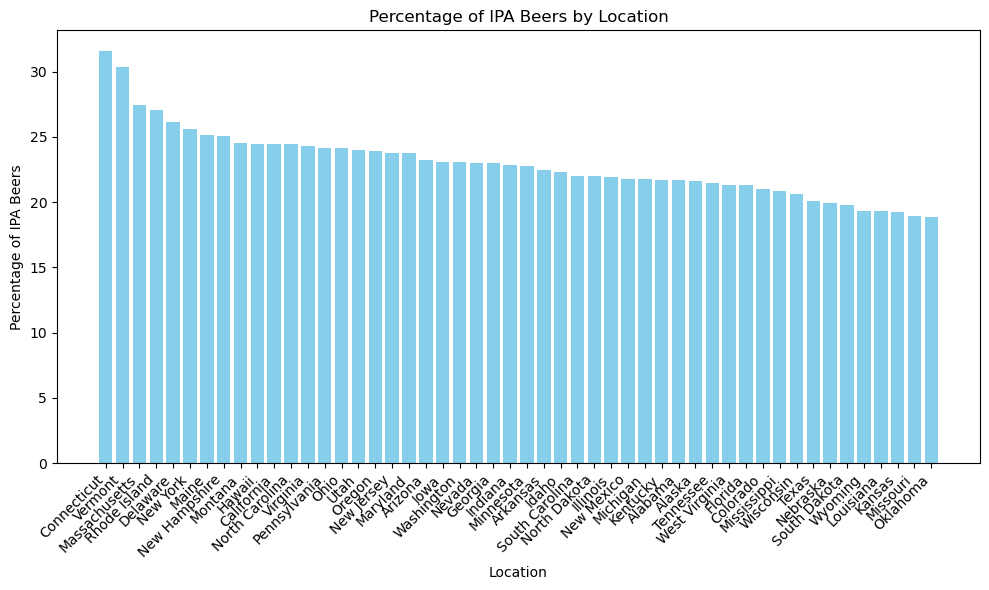

In [341]:
american_states['states'] = american_states['location'].apply(clean_states)
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(american_states['states'], american_states['IPA_Percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage of IPA Beers')
plt.title('Percentage of IPA Beers by Location')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

**Let's investigate if IPAs tend to come from bigger breweries**

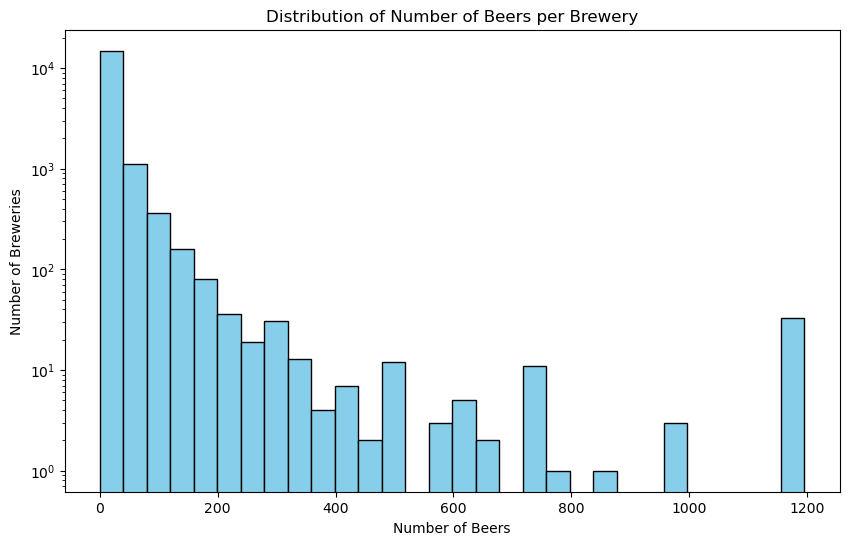

In [343]:
plt.figure(figsize=(10, 6))
plt.hist(ba_breweries_df['nbr_beers'], bins=30, color='skyblue', edgecolor='black', log=True)
plt.title('Distribution of Number of Beers per Brewery')
plt.xlabel('Number of Beers')
plt.ylabel('Number of Breweries')
plt.show()

In [344]:
merged_df_brew = pd.merge(ba_beers_df, ba_breweries_df, left_on='brewery_id', right_on='brewery_id', how='left')
merged_df_brew['is_IPA'] = merged_df_brew['style'].isin(macro_group['IPA'])
print(merged_df_brew)

        beer_id           beer_name  brewery_id  \
0        166064    Nashe Moskovskoe       39912   
1        166065     Nashe Pivovskoe       39912   
2        166066  Nashe Shakhterskoe       39912   
3        166067  Nashe Zhigulevskoe       39912   
4        166063              Zhivoe       39912   
...         ...                 ...         ...   
280818    19139          Kölsch Ale         885   
280819    19140       Nut Brown Ale         885   
280820    19146         Octoberfest         885   
280821     2805          Scotch Ale         885   
280822    19148       Smoked Porter         885   

                               brewery_name                   style  \
0                    Abdysh-Ata (Абдыш Ата)         Euro Pale Lager   
1                    Abdysh-Ata (Абдыш Ата)         Euro Pale Lager   
2                    Abdysh-Ata (Абдыш Ата)         Euro Pale Lager   
3                    Abdysh-Ata (Абдыш Ата)         Euro Pale Lager   
4                    Abdysh-Ata 

In [345]:
average_beers_by_brewery = merged_df_brew.groupby(['is_IPA'])['nbr_beers'].mean().reset_index()
print(average_beers_by_brewery)

   is_IPA   nbr_beers
0   False   99.687014
1    True  112.922218


It looks like that in average IPA beers are brewed by bigger breweries

In [ ]:
#Let's say that a big brewery is a brewery brewing more than 200 beers. Let's see how many ratings
#come from small or big breweries depending if it's an IPA or not
final_merged_df['big_brewery'] = final_merged_df['nbr_beers'] > 200
grouped_df = final_merged_df.groupby(['macro_group', 'big_brewery']).size().reset_index(name='count')
print(grouped_df)

  macro_group  big_brewery    count
0         IPA        False   997506
1         IPA         True   826706
2       Other        False  4074452
3       Other         True  2033629


In [360]:
ipa_count = grouped_df[(grouped_df['macro_group'] == 'IPA') & (grouped_df['big_brewery'] == False)]['count'].values[0]
big_brewery_count = grouped_df[(grouped_df['macro_group'] == 'IPA') & (grouped_df['big_brewery'] == True)]['count'].values[0]

# Performing the calculation
result = big_brewery_count / (ipa_count + big_brewery_count)*100

# Printing the result
print("Percentage big brewery for IPA = ", result)


Percentage big brewery for IPA =  45.31852657476214


In [361]:
non_ipa_count = grouped_df[(grouped_df['macro_group'] == 'Other') & (grouped_df['big_brewery'] == False)]['count'].values[0]
non_ipa_big_brewery_count = grouped_df[(grouped_df['macro_group'] == 'Other') & (grouped_df['big_brewery'] == True)]['count'].values[0]

# Performing the calculation
result = non_ipa_big_brewery_count / (non_ipa_count + non_ipa_big_brewery_count)*100

# Printing the result
print("Percentage big brewery for IPA = ", result)

Percentage big brewery for IPA =  33.29407386706234


In [364]:
grouped_df = final_merged_df.groupby(['year', 'macro_group', 'big_brewery']).size().reset_index(name='count')
print(grouped_df)

    year macro_group  big_brewery   count
0   2008         IPA        False   15083
1   2008         IPA         True   11960
2   2008       Other        False  125183
3   2008       Other         True   42628
4   2009         IPA        False   19073
5   2009         IPA         True   18829
6   2009       Other        False  139956
7   2009       Other         True   55395
8   2010         IPA        False   24587
9   2010         IPA         True   21435
10  2010       Other        False  154961
11  2010       Other         True   70001
12  2011         IPA        False   46752
13  2011         IPA         True   46652
14  2011       Other        False  280004
15  2011       Other         True  150851
16  2012         IPA        False   79419
17  2012         IPA         True   88498
18  2012       Other        False  476716
19  2012       Other         True  243858
20  2013         IPA        False  131306
21  2013         IPA         True  153071
22  2013       Other        False 

macro_group        IPA      Other
year                             
2008         44.225863  25.402387
2009         49.678117  28.356650
2010         46.575551  31.116811
2011         49.946469  35.012011
2012         52.703419  33.842187
2013         53.826786  35.432520
2014         48.903474  34.754541
2015         40.540385  32.598619
2016         35.753897  31.685160
2017         31.937071  29.945491


<Figure size 1000x600 with 0 Axes>

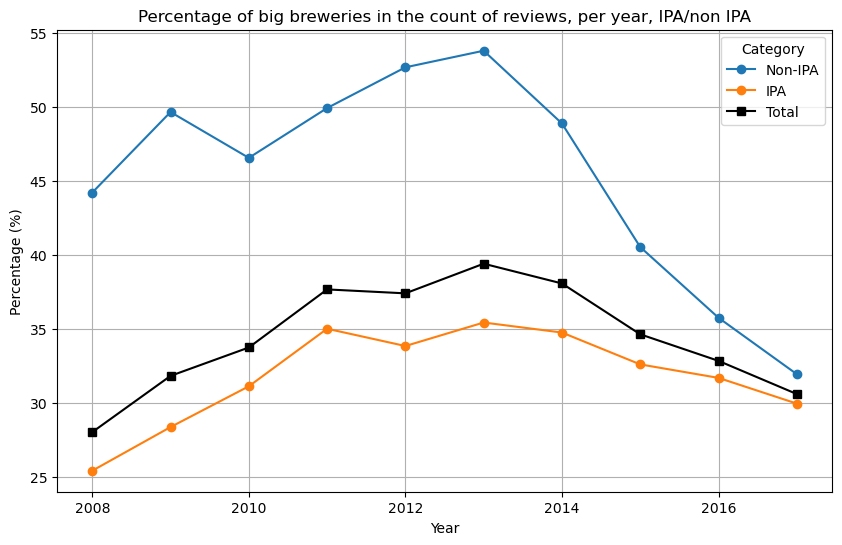

In [ ]:
total_counts = grouped_df.groupby(['year', 'macro_group'])['count'].sum().unstack()

# Calculate counts of IPA and non-IPA from big breweries
big_brewery_counts = grouped_df[grouped_df['big_brewery'] == True].groupby(['year', 'macro_group'])['count'].sum().unstack()

# Calculate percentage of IPA and non-IPA from big breweries
percentage_big_brewery = big_brewery_counts.div(total_counts) * 100

#For each year we'll have 
print(percentage_big_brewery)

# Calculate the total beer counts from big breweries and total beer counts for each year
total_big_brewery_counts = grouped_df[grouped_df['big_brewery'] == True].groupby('year')['count'].sum()
total_all_counts = grouped_df.groupby('year')['count'].sum()

# Calculate the total percentage of all beer from big breweries
percentage_total_big_brewery = total_big_brewery_counts.div(total_all_counts) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot the percentage of IPA, non-IPA, and total from big breweries
percentage_big_brewery.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6))
plt.plot(percentage_total_big_brewery, marker='s', linestyle='-', color='black', label='Total Big Brewery')

# Adding labels and title
plt.title('Percentage of big breweries in the count of reviews, per year, IPA/non IPA')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(title='Category', labels=['Non-IPA', 'IPA', 'Total'])

# Display the plot
plt.grid(True)
plt.show()

**Let's investigate if the IPA is a seasonal beer**

In [378]:
per_month_df = final_merged_df.groupby('month')['rating'].size().reset_index()
per_month_df = per_month_df.rename(columns={
    'month': 'Month',
    'rating': 'Number of Ratings'
})
print(per_month_df)

    Month  Number of Ratings
0       1             690616
1       2             617422
2       3             684692
3       4             627747
4       5             677935
5       6             676267
6       7             709764
7       8             657405
8       9             583069
9      10             605159
10     11             708960
11     12             693257


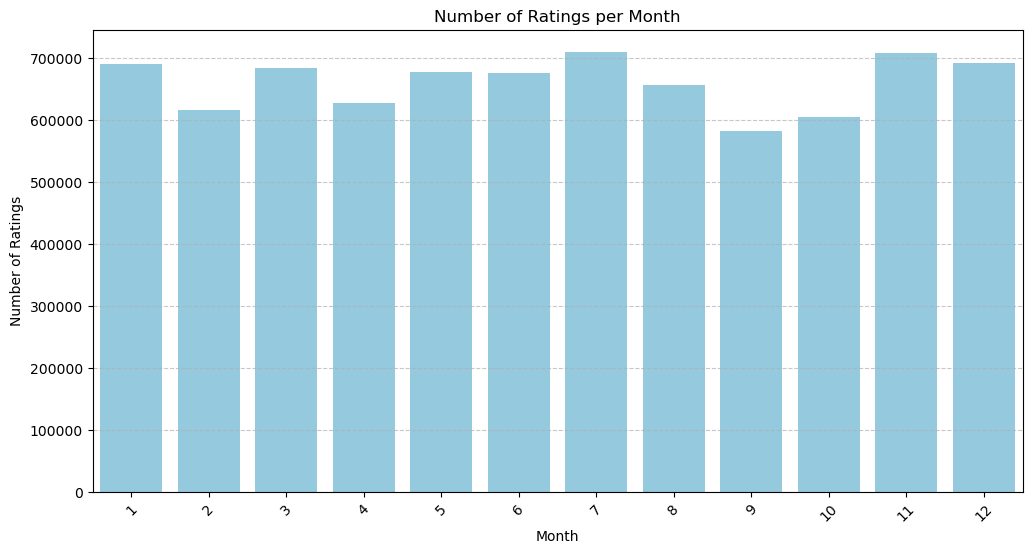

In [379]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', color='skyblue')

# Customize the plot
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [380]:
per_month_df = final_merged_df.groupby(['month', 'macro_group'])['rating'].size().reset_index()
per_month_df = per_month_df.rename(columns={
    'month': 'Month',
    'rating': 'Number of Ratings'
})
print(per_month_df)

    Month macro_group  Number of Ratings
0       1         IPA             144858
1       1       Other             545758
2       2         IPA             142748
3       2       Other             474674
4       3         IPA             165035
5       3       Other             519657
6       4         IPA             156786
7       4       Other             470961
8       5         IPA             165384
9       5       Other             512551
10      6         IPA             167865
11      6       Other             508402
12      7         IPA             177532
13      7       Other             532232
14      8         IPA             156312
15      8       Other             501093
16      9         IPA             130249
17      9       Other             452820
18     10         IPA             134474
19     10       Other             470685
20     11         IPA             146544
21     11       Other             562416
22     12         IPA             136425
23     12       

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\1692377028.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', hue='macro_group', color='skyblue')


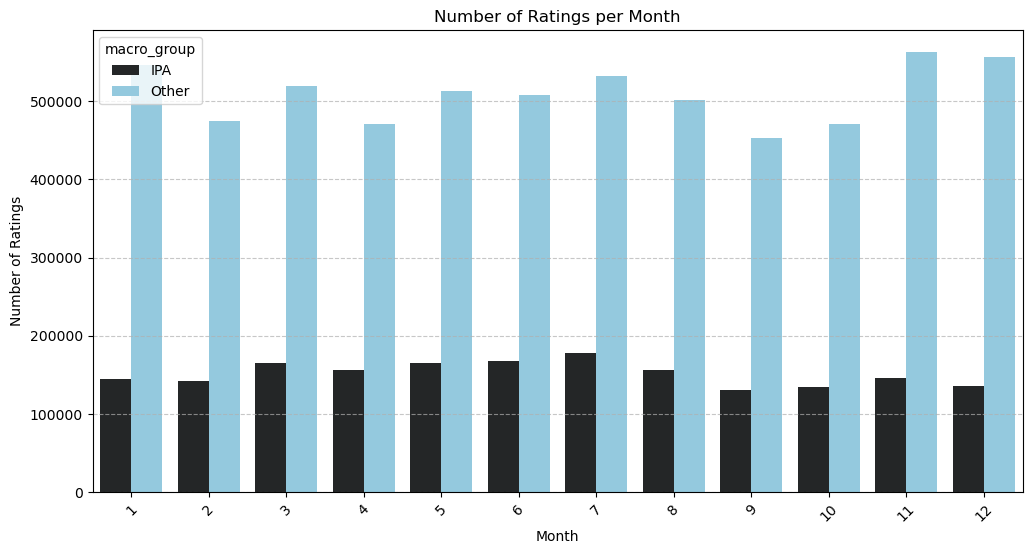

In [381]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', hue='macro_group', color='skyblue')

# Customize the plot
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [383]:
monthly_totals = per_month_df.groupby('Month')['Number of Ratings'].sum().reset_index(name='Total Ratings')

# Merge monthly totals back into the original DataFrame
df = pd.merge(per_month_df, monthly_totals, on='Month')

# Calculate IPA percentage
df['IPA Percentage'] = df.apply(lambda row: (row['Number of Ratings'] / row['Total Ratings']) * 100 
                                if row['macro_group'] == 'IPA' else None, axis=1)

# Drop rows with None in 'IPA Percentage' to only keep IPA rows
ipa_percentages = df.dropna(subset=['IPA Percentage'])[['Month', 'IPA Percentage']]
print(ipa_percentages)

    Month  IPA Percentage
0       1       20.975187
2       2       23.120005
4       3       24.103539
6       4       24.975986
8       5       24.395259
10      6       24.822297
12      7       25.012821
14      8       23.777124
16      9       22.338523
18     10       22.221267
20     11       20.670278
22     12       19.678849


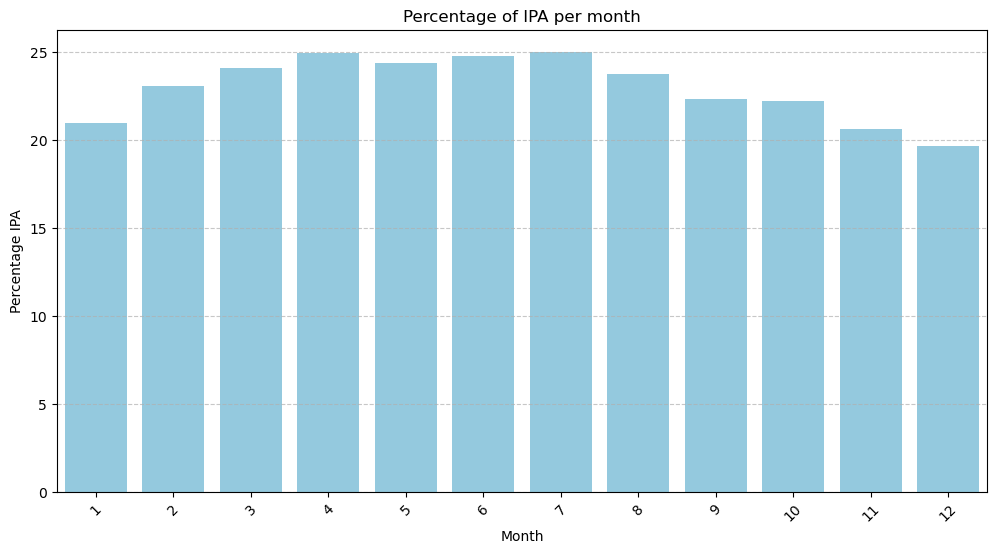

In [385]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=ipa_percentages, x='Month', y='IPA Percentage', color='skyblue')

# Customize the plot
plt.title('Percentage of IPA per month')
plt.xlabel('Month')
plt.ylabel('Percentage IPA')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

**Let's find out if there is an evolution in term of amount of alcohol**

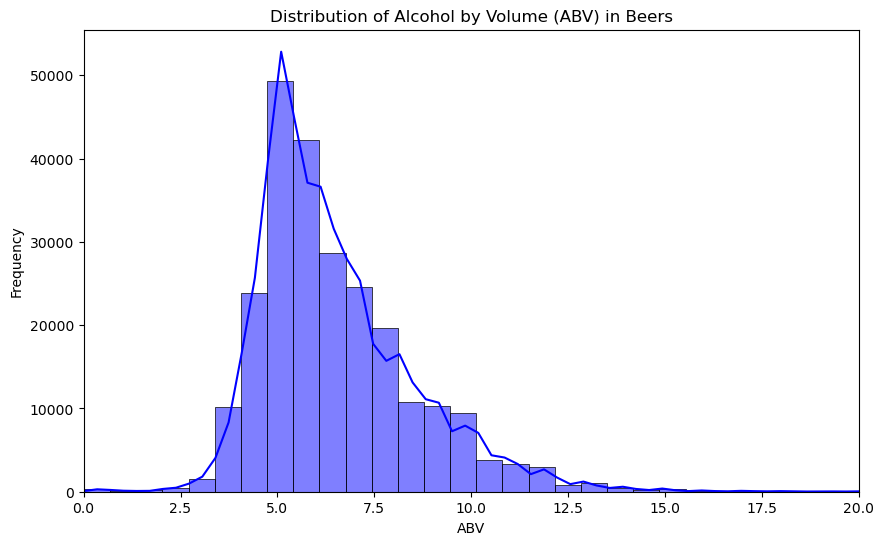

In [431]:
plt.figure(figsize=(10,6))
sns.histplot(ba_beers_df['abv'].dropna(), kde=True, color='blue', bins=100)
plt.title("Distribution of Alcohol by Volume (ABV) in Beers")
plt.xlabel("ABV")
plt.ylabel("Frequency")
plt.xlim(0, 20)
plt.show()

In [436]:
yearly_abv_df = final_merged_df.groupby('year')['abv'].median().reset_index()
print(yearly_abv_df)

   year  abv
0  2008  6.5
1  2009  6.7
2  2010  6.9
3  2011  7.0
4  2012  6.8
5  2013  7.0
6  2014  6.9
7  2015  7.0
8  2016  6.9
9  2017  7.0


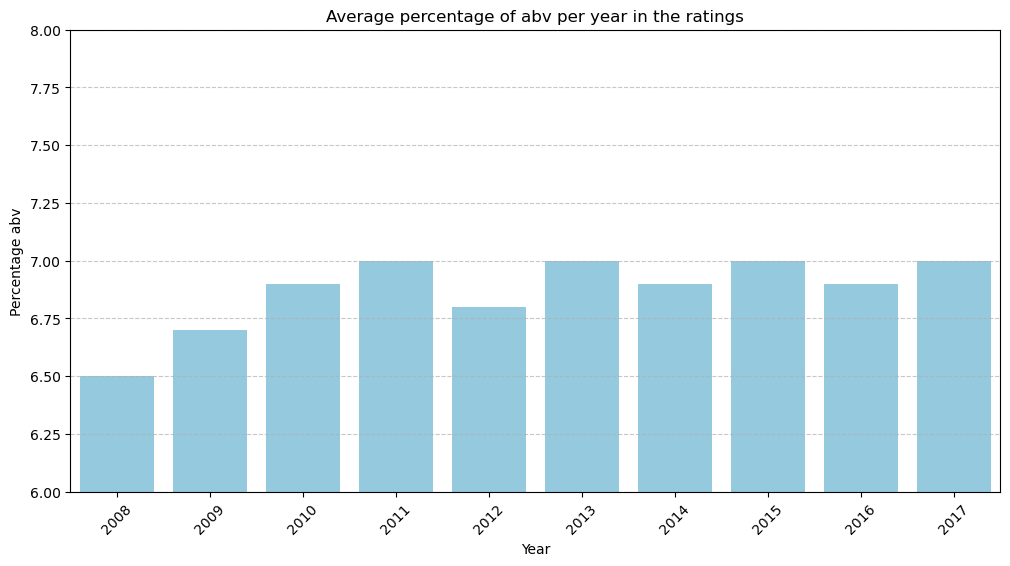

In [437]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=yearly_abv_df, x='year', y='abv', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(6, 8)

# Display the plot
plt.show()

In [438]:
yearly_abv_df = final_merged_df.groupby(['year', 'macro_group'])['abv'].median().reset_index()
print(yearly_abv_df)

    year macro_group   abv
0   2008         IPA  7.10
1   2008       Other  6.00
2   2009         IPA  7.20
3   2009       Other  6.25
4   2010         IPA  7.50
5   2010       Other  6.50
6   2011         IPA  7.50
7   2011       Other  6.70
8   2012         IPA  7.40
9   2012       Other  6.30
10  2013         IPA  7.50
11  2013       Other  6.60
12  2014         IPA  7.40
13  2014       Other  6.50
14  2015         IPA  7.20
15  2015       Other  6.50
16  2016         IPA  7.20
17  2016       Other  6.50
18  2017         IPA  7.20
19  2017       Other  6.40


C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\3257971005.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=yearly_abv_df, x='year', y='abv', hue='macro_group', color='skyblue')


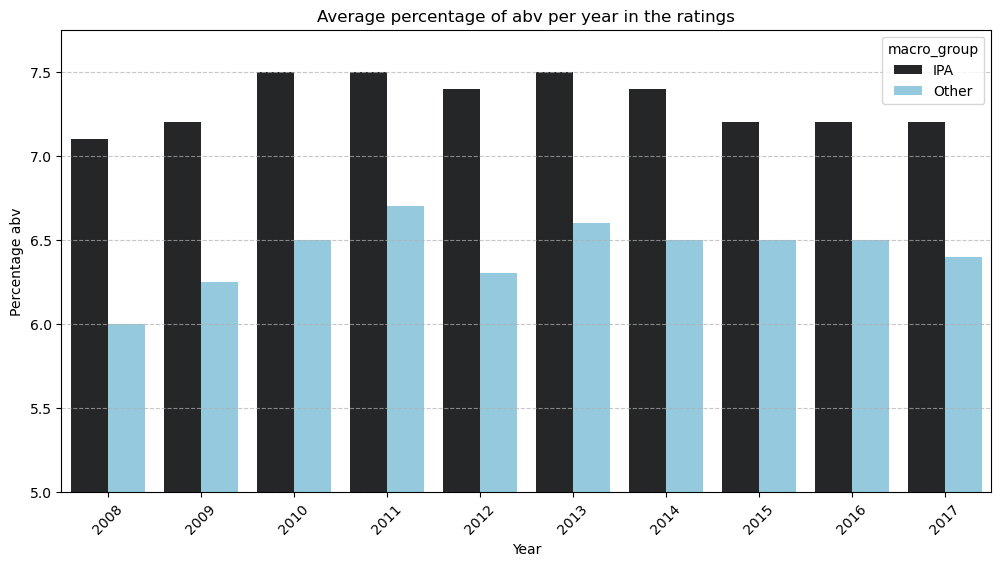

In [440]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=yearly_abv_df, x='year', y='abv', hue='macro_group', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(5, 7.75)

# Display the plot
plt.show()

In [443]:
threshold = 4.5
final_merged_df['good_rating'] = final_merged_df['rating'] > threshold
abv_depend_ratings = final_merged_df.groupby(['good_rating', 'year'])['abv'].median().reset_index().copy()
print(abv_depend_ratings)

    good_rating  year   abv
0         False  2008  6.20
1         False  2009  6.50
2         False  2010  6.80
3         False  2011  6.80
4         False  2012  6.60
5         False  2013  6.90
6         False  2014  6.75
7         False  2015  6.80
8         False  2016  6.70
9         False  2017  6.80
10         True  2008  8.20
11         True  2009  8.30
12         True  2010  8.30
13         True  2011  8.30
14         True  2012  8.30
15         True  2013  8.60
16         True  2014  8.30
17         True  2015  8.10
18         True  2016  8.20
19         True  2017  8.20


C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_15664\3160200592.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=abv_depend_ratings, x='year', y='abv', hue='good_rating', color='skyblue')


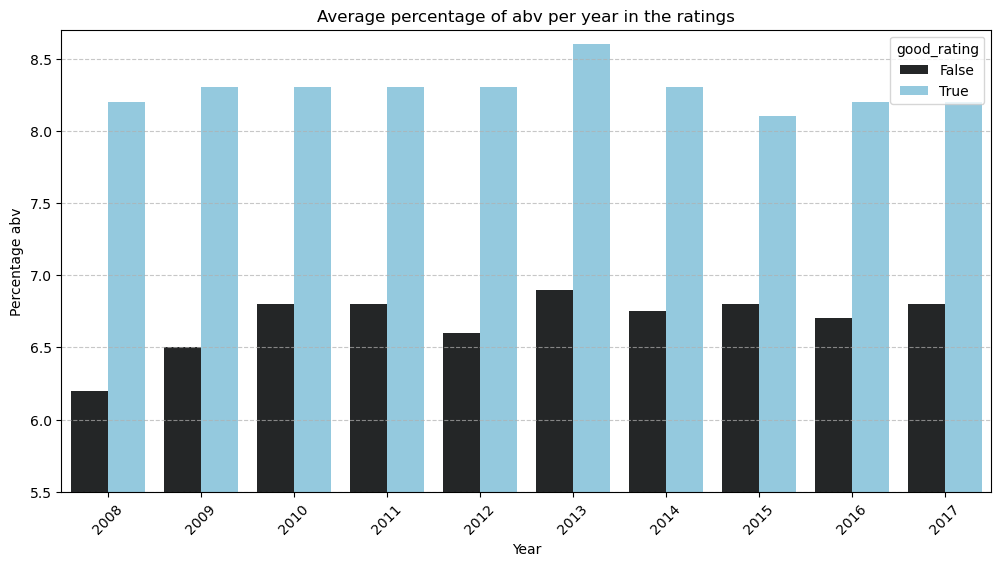

In [446]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=abv_depend_ratings, x='year', y='abv', hue='good_rating', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(5.5, 8.7)

# Display the plot
plt.show()